passilove zousnobu
(1024, 64, 256)
output: (1024, 64, 256), state: (1024, 512)
meanedLSTMOutput: (1024, 256)
fullyLayer: readout, shape: (1024, 256) --> (1024, 2)
afterFull: (1024, 2), crossEnt: ()
Tensor("Assign_1:0", shape=(1024, 512), dtype=float32_ref)


<IPython.core.display.Javascript object>


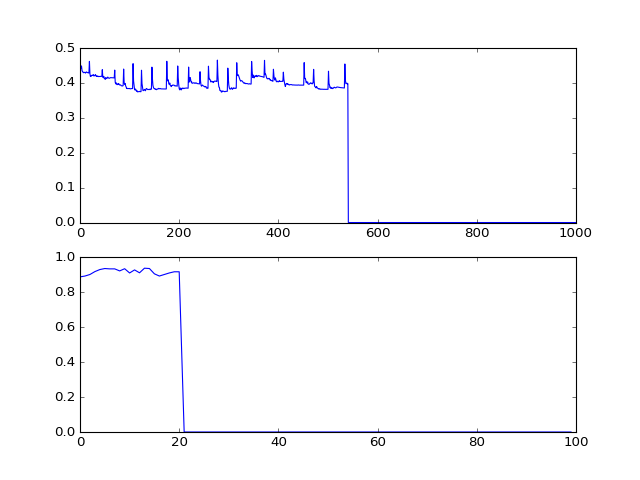

restored variables
starting epoch ---------
path: saves/v1.cpkt
accuracy: 0.8671875
accuracy: 0.8671875
accuracy: 0.859375
accuracy: 0.861328125
accuracy: 0.8623046875
accuracy: 0.87109375
accuracy: 0.8759765625
accuracy: 0.86328125
accuracy: 0.861328125
accuracy: 0.859375
accuracy: 0.8603515625
accuracy: 0.873046875
accuracy: 0.8818359375
accuracy: 0.85546875
accuracy: 0.8857421875
accuracy: 0.8447265625
accuracy: 0.8681640625
accuracy: 0.85546875
accuracy: 0.85546875
accuracy: 0.8837890625
accuracy: 0.8681640625
accuracy: 0.873046875
accuracy: 0.8681640625
accuracy: 0.8955078125
totaltestAccuracy: 0.8673909505208334


In [ ]:

import tensorflow as tf
from DataHandle import DataHandle
import numpy as np

#import matplotlib
#matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
%matplotlib notebook


FLAGS = type('FLAGS', (), {})
FLAGS.embeddingSize = 256
FLAGS.memorySize = 256
FLAGS.batchSize = 1024
FLAGS.seqLength = 64
FLAGS.stdActFun = tf.nn.sigmoid
FLAGS.crossEntropy = tf.nn.sparse_softmax_cross_entropy_with_logits
FLAGS.optimizer = tf.train.AdamOptimizer
FLAGS.learningRate = 0.0005
FLAGS.nEpochs = 1
FLAGS.plotEveryN = 20
FLAGS.saveEveryN = 500

class LSTM:

    def __init__(self, dataHandle):
        tf.reset_default_graph()
        self.data_handle = dataHandle

        self.buildNetwork()
        self.buildStateResetOP()

    def getEmbeding(self):
        with tf.variable_scope("embedding"):
            embeddings = tf.get_variable("embed", [self.data_handle.vocabSize, FLAGS.embeddingSize], tf.float32, tf.random_uniform_initializer(-1.0, 1.0))

        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
        normalized_embeddings = embeddings / norm
        #normalizedEmbed = tf.nn.embedding_lookup((normalized_embeddings, wordIds))

        return embeddings, normalized_embeddings

    def fullyLayer(self, input, outputSize, name, actFunction=FLAGS.stdActFun):
        #print("bla: {}".format(input.get_shape()))
        _nExamples, nNeuronsInput = input.get_shape()
        with tf.variable_scope(name):
            weights = tf.get_variable("weights", shape=[nNeuronsInput, outputSize],
                                      initializer=tf.random_normal_initializer(stddev=0.05))
            bias = tf.get_variable("bias", shape=[outputSize], initializer=tf.constant_initializer(0.0))

            internalActivation = tf.matmul(input, weights)
            result = actFunction(internalActivation + bias)
        print("fullyLayer: {}, shape: {} --> {}".format(name, input.get_shape(), result.get_shape()))
        return result

    def buildStateResetOP(self):
        self.resetStateOP = self.state.assign(self.lstmCell.zero_state(FLAGS.batchSize, tf.float32))
        print(self.resetStateOP)

    def buildNetwork(self):
        self.input = tf.placeholder(tf.int64, shape=[FLAGS.batchSize, FLAGS.seqLength])
        self.desired = tf.placeholder(tf.int64, shape=[FLAGS.batchSize, ])

        self.embedding, self.normalized_embeddings = self.getEmbeding()

        self.embeded = tf.nn.embedding_lookup(self.embedding, self.input)

        print(self.embeded.get_shape())

        self.lstmCell = tf.contrib.rnn.BasicLSTMCell(FLAGS.memorySize, state_is_tuple=False)

        zeroState = self.lstmCell.zero_state(FLAGS.batchSize, tf.float32)
        self.state = tf.Variable(zeroState, trainable=False)

        outputsUnasigned, newState = tf.nn.dynamic_rnn(self.lstmCell, self.embeded, initial_state=self.state)

        with tf.control_dependencies([self.state.assign(newState)]):
            self.outputLSTM = tf.identity(outputsUnasigned)


        print("output: {}, state: {}".format(self.outputLSTM.get_shape(), self.state.get_shape()))

        meanedLSTMOutput = tf.reduce_mean(self.outputLSTM, axis=1)

        print("meanedLSTMOutput: {}".format(meanedLSTMOutput.shape))

        self.afterFull = self.fullyLayer(meanedLSTMOutput, 2, 'readout')

        crossEnt = FLAGS.crossEntropy(logits=self.afterFull, labels=self.desired)
        self.crossEntropy = tf.reduce_mean(crossEnt)

        self.optimizer = FLAGS.optimizer(learning_rate=FLAGS.learningRate)

        self.trainingStep = self.optimizer.minimize(self.crossEntropy)

        self.probDist = tf.nn.softmax(self.afterFull)
        
        self.prediction = tf.argmax(self.afterFull, 1)
        self.nCorrect = tf.equal(self.prediction, self.desired)
        # accuracy = tf.equal(tf.argmax(output_ron_2,1), tf.argmax(desired,1))
        self.accuracy = tf.reduce_mean(tf.cast(self.nCorrect, tf.float32))

        print("afterFull: {}, crossEnt: {}".format(self.afterFull.get_shape(), self.crossEntropy.get_shape()))

def checkAccuracy(lstm=None, session=None, data_handle=None):
    accuracyPlotWindow = 100
    accuracyTrace = []
    
    for batch_data in data_handle.epoch(FLAGS.batchSize, FLAGS.seqLength, testData=True):
        sequences, label = batch_data

        #reset hidden state
        session.run(lstm.resetStateOP)
        #print('new Sequences')
        currentOutputs = np.zeros((len(sequences), FLAGS.batchSize, 2),dtype=float)
        for i_subSeq,subSeq in enumerate(sequences):
            (netOutput,) = session.run([lstm.probDist], feed_dict={lstm.input: subSeq, lstm.desired: label})
            
            #print(netOutput)
            currentOutputs[i_subSeq, :, :] = netOutput
                
                        
        #calculate the accuracy of values in this sequence
        
        # mean over the outputs of all subsequences
        meanedOutputs = np.mean(currentOutputs, axis=0)
        #print(meanedOutputs.shape)
        classificationResults = np.argmax(meanedOutputs, axis=1)
        #print(classificationResults)
        accuracy = np.mean(classificationResults == label)
        print("accuracy: {}".format(accuracy))
        
        accuracyTrace.append(accuracy)

        
    totalAcc = np.mean(accuracyTrace)
    print("totaltestAccuracy: {}".format(totalAcc))
    return totalAcc
        
        
        
        
        
        
        
data_handle = DataHandle('imdbData.pickle')
lstm = LSTM(data_handle)
# lstm = LSTM(type('DataHandle', (), {'vocabSize':60000}))



savePath = 'saves/v1.cpkt'
restorePath = 'saves/v1.cpkt'
#restorePath = None
#savePath = None


plt.ion()
Fig, axes = plt.subplots(2, 1)
entropyAx, accuracyAx = axes

Fig.show()
#plt.show()

plotWindow = 1000

i_current_batch = 0
losses = np.zeros(plotWindow)

i_current_seq = 0
accuracyPlotWindow = 100
accuracyTrace = np.zeros(accuracyPlotWindow)

with tf.Session() as session:
    train_writer = tf.summary.FileWriter('summary/bla', session.graph)

    saver = tf.train.Saver()
    if (restorePath is None):
        session.run(tf.global_variables_initializer())
        print("initialized variables")
    else:
        saver.restore(session, restorePath)
        print("restored variables")

    
    
    for current_epoch in range(FLAGS.nEpochs):
        print("starting epoch ---------")
        for batch_data in data_handle.epoch(FLAGS.batchSize, FLAGS.seqLength):
            sequences, label = batch_data

            #reset hidden state
            session.run(lstm.resetStateOP)
            #print('new Sequences')
            currentOutputs = np.zeros((len(sequences), FLAGS.batchSize, 2),dtype=float)
            for i_subSeq,subSeq in enumerate(sequences):
                _, lossvalue, netOutput = session.run([lstm.trainingStep, lstm.crossEntropy, lstm.probDist], feed_dict={lstm.input: subSeq, lstm.desired: label})
                losses[i_current_batch] = lossvalue
                currentOutputs[i_subSeq, :, :] = netOutput
                
                #print("debugVal: {}".format(debugVal))
                # print("{} <- label".format(label))

                if(i_current_batch % FLAGS.plotEveryN == 0):
                    entropyAx.clear()
                    entropyAx.plot(losses)
                    Fig.canvas.draw()
                    #plt.pause(0.0001)

                i_current_batch+=1

                if(i_current_batch % plotWindow == 0):
                    #the next i would be out of bounds for losses. so we need to append another window
                    losses = np.concatenate([losses, np.zeros(plotWindow)])

                if(i_current_batch % FLAGS.saveEveryN == 0):

                    if (not savePath is None):
                        path = saver.save(session, savePath)

                        print("path: {}".format(path))
                        
            #calculate the accuracy of values in this sequence
            
            # mean over the outputs of all subsequences
            meanedOutputs = np.mean(currentOutputs, axis=0)
            #print(meanedOutputs.shape)
            classificationResults = np.argmax(meanedOutputs, axis=1)
            #print(classificationResults)
            accuracyTrace[i_current_seq] = np.mean(classificationResults == label)
            #print("accuracy: {}".format(accuracy))
            
            
            if(i_current_seq % 5 == 0):
                accuracyAx.clear()
                accuracyAx.plot(accuracyTrace)
                Fig.canvas.draw()
                #plt.pause(0.0001)
                
            i_current_seq+=1
            if(i_current_seq % plotWindow == 0):
                #the next i would be out of bounds for losses. so we need to append another window
                accuracyTrace = np.concatenate([accuracyTrace, np.zeros(accuracyPlotWindow)])

    checkAccuracy(lstm=lstm, data_handle=data_handle, session=session)
         
    final_embeddings = lstm.normalized_embeddings.eval()


def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert(low_dim_embs.shape[0] >= len(labels))
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

    #plt.savefig(filename)
    plt.show()


from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [data_handle.id2word[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)